In [3]:
def visualize_grid_2d_rgb(
    grid,
    figsize=None,        # 예: (8, 6)
    dpi=None,           # 예: 150, 300
    show_legend=True,   # 오른쪽에 목차(legend) 표시 여부
    transparent_bg=False,  # 0 값(outside)을 투명하게 표현할지 여부
):
    """
    파이썬 2중 리스트(예: [[0,1,2,...], [...], ...])를
    RGB 이미지로 시각화 (축/테두리 없이 데이터만).

    - show_legend: True면 오른쪽에 색/값 목차를 따로 그려줌
    - transparent_bg: True면 값 0(outside)을 완전 투명(alpha=0)으로 표현
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle

    arr = np.array(grid)  # (H, W)

    if arr.ndim != 2:
        raise ValueError("grid 는 2차원 리스트/배열이어야 합니다.")

    H, W = arr.shape

    # 값별 색상 정의 (0~1 범위 RGB)
    # 0: 짙은 회색, 1: 흰색, 2: 흰색(테두리는 따로 그림), 3: 빨간색
    value_to_color = {
        0: (0.25, 0.25, 0.25),  # outside  짙은 회색
        1: (1.00, 1.00, 1.00),  # job site 흰색
        2: (1.00, 1.00, 1.00),  # installable 흰색 (테두리는 아래에서 patch로)
        3: (0.25, 0.25, 0.25),  # constraint 빨강
    }
    value_to_label = {
        0: "0: outside",
        1: "1: job site",
        2: "2: installable",
        3: "3: constraint",
    }

    # --- 이미지 버퍼 준비 (RGB 또는 RGBA) ---
    if transparent_bg:
        img = np.zeros((H, W, 4), dtype=float)  # RGBA (alpha 포함)
    else:
        img = np.zeros((H, W, 3), dtype=float)  # RGB

    # 각 값에 대해 색 채우기
    for v, color in value_to_color.items():
        mask = (arr == v)
        if not np.any(mask):
            continue

        if transparent_bg and v == 0:
            # outside(0)은 알파 0으로 투명하게 두기
            continue
        if transparent_bg:
            r, g, b = color
            img[mask, 0] = r
            img[mask, 1] = g
            img[mask, 2] = b
            img[mask, 3] = 1.0  # 불투명
        else:
            img[mask] = color

    # --- Figure & Axes: 여백 없이, 옆에 legend용 공간 확보 ---
    if show_legend:
        fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
        if transparent_bg:
            fig.patch.set_alpha(0.0)  # 전체 figure 배경도 투명

        ax_img = fig.add_axes([0.0, 0.0, 0.85, 1.0])   # [left, bottom, width, height]
        ax_leg = fig.add_axes([0.85, 0.0, 0.15, 1.0])
        ax_leg.axis("off")
    else:
        fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
        if transparent_bg:
            fig.patch.set_alpha(0.0)
        ax_img = fig.add_axes([0.0, 0.0, 1.0, 1.0])
        ax_leg = None

    # 데이터 이미지 표시
    ax_img.imshow(img, origin="upper")
    ax_img.set_aspect("equal", adjustable="box")
    ax_img.axis("off")

    # === 값 2에 대해 모든 테두리를 빨간 선으로 그리기 ===
    # arr == 2 인 셀마다 1x1 크기의 사각형 패치(테두리만, 빨강)를 올린다.
    ys, xs = np.where(arr == 2)
    border_color = (0.90, 0.00, 0.00)  # 값 3과 동일한 빨강으로 사용
    for y, x in zip(ys, xs):
        rect = Rectangle(
            (x - 0.5, y - 0.5),   # 셀 중심이 (x, y)이므로, 좌측상단은 (x-0.5, y-0.5)
            1.0,
            1.0,
            fill=False,
            edgecolor=border_color,
            linewidth=1.5,
            transform=ax_img.transData,
            clip_on=False,
        )
        ax_img.add_patch(rect)

    # 🔽🔽 legend 세로 크기/간격 자동 조정 + 값 2는 흰색 바탕 + 빨간 테두리 🔽🔽
    if show_legend and ax_leg is not None:
        keys = sorted(value_to_color.keys())
        n = len(keys)

        # legend를 차지하는 세로 영역 (top~bottom)
        top = 0.85
        bottom = 0.15
        total_h = top - bottom
        dy = total_h / max(n, 1)   # 항목 간 간격
        rect_h = dy * 0.2          # 박스 높이

        for i, v in enumerate(keys):
            # 각 항목의 중심 y 위치
            y_center = top - (i + 0.5) * dy
            rect_y = y_center - rect_h / 2

            facecolor = value_to_color[v]
            edgecolor = "none"

            # 값 2는 legend에서도 흰색 바탕 + 빨간 테두리로 표시
            if v == 2:
                edgecolor = border_color

            ax_leg.add_patch(
                Rectangle(
                    (0.05, rect_y), 0.20, rect_h,
                    transform=ax_leg.transAxes,
                    facecolor=facecolor,
                    edgecolor=edgecolor,
                    linewidth=2.0,
                    clip_on=False
                )
            )

            # 텍스트는 박스 중앙 y에 정렬
            ax_leg.text(
                0.30, y_center,
                value_to_label.get(v, str(v)),
                transform=ax_leg.transAxes,
                va="center",
                fontsize=20
            )

    plt.show()


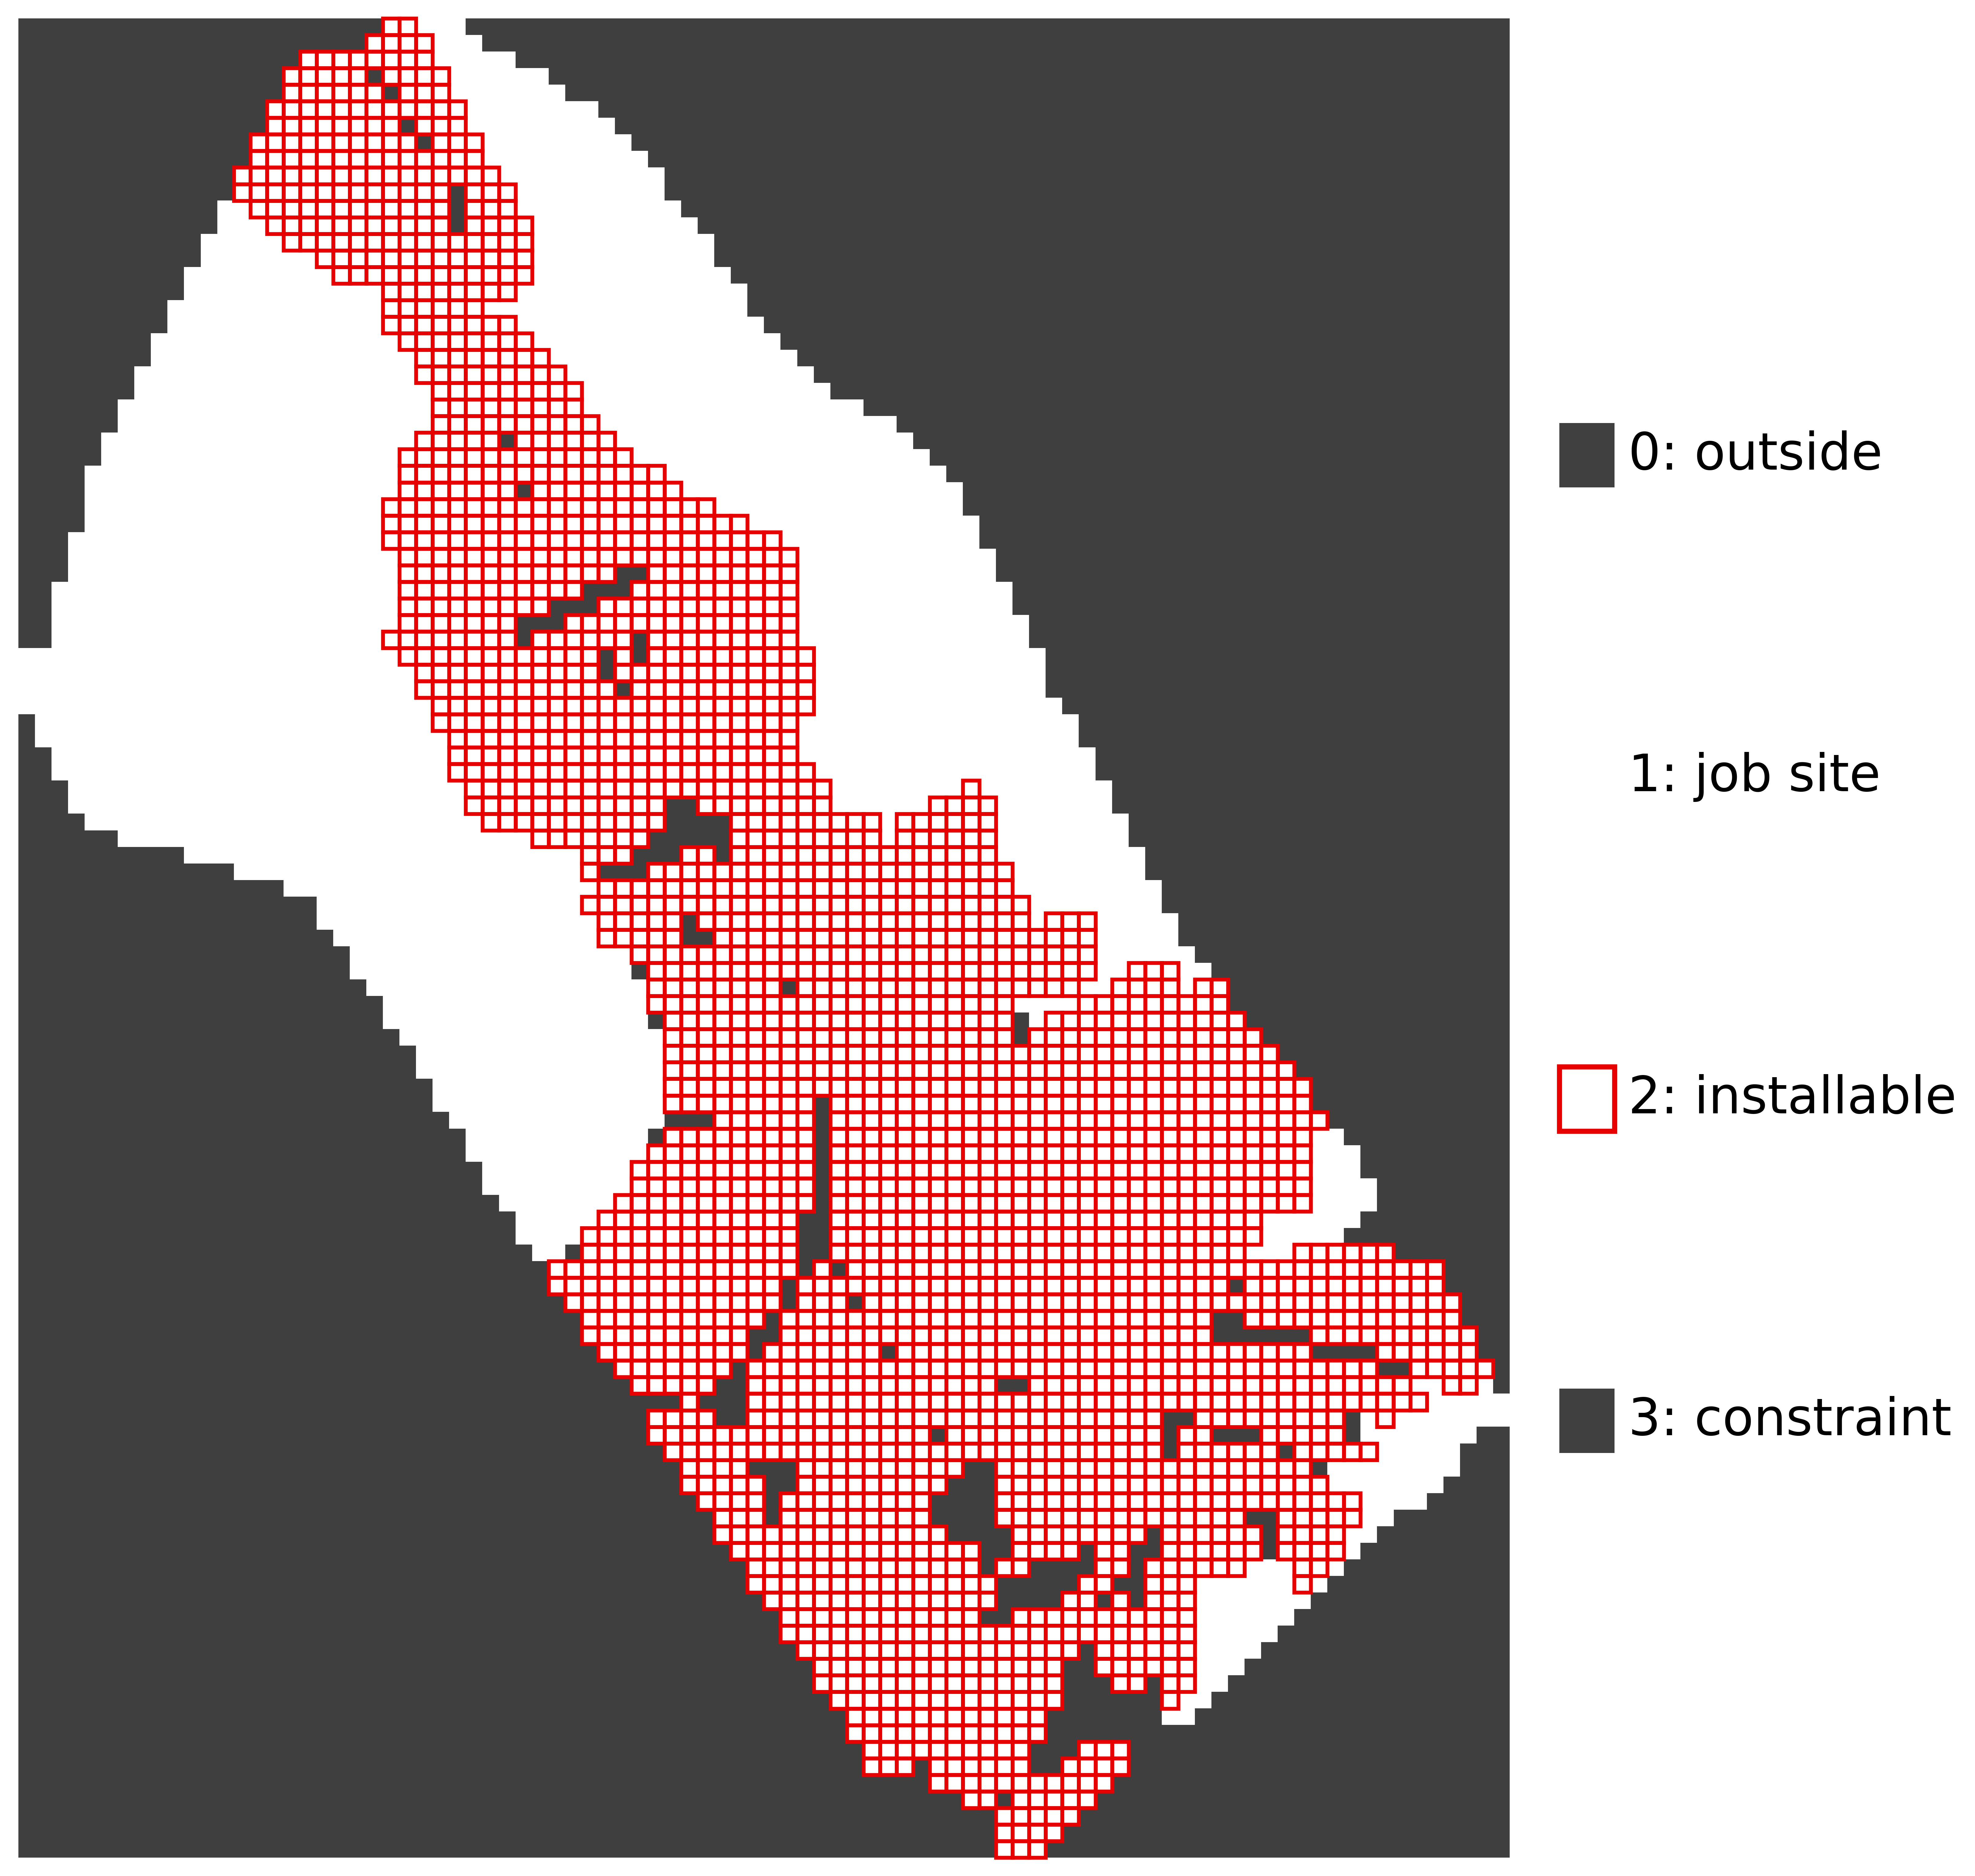

In [2]:
from final_grid import GRID  # 혹은 4.final_grid.py 에서 GRID 가져왔다고 가정

# outside(0) 영역을 완전 투명하게 (PNG로 저장할 때 유용)
visualize_grid_2d_rgb(
    GRID,
    figsize=(10, 10),
    dpi=600,
    show_legend=True,
    transparent_bg=False,
)